# **Semana 13: Métricas Avanzadas de Evaluación**

## Ciencia de Datos en el Deporte - Análisis Avanzado

### **Bloque 3: Análisis Avanzado y Modelado**

---

**Objetivos de Aprendizaje:**
- Dominar ROC-AUC para evaluar modelos de clasificación
- Implementar curvas Precision-Recall
- Entender métricas específicas por clase
- Interpretar resultados en contexto deportivo
- Seleccionar métricas apropiadas según el problema

**Herramientas:**
- Python
- Scikit-learn (métricas avanzadas)
- Matplotlib/Seaborn (visualización de métricas)
- ROC curves, Precision-Recall curves
- Classification reports detallados

---

## 1. Repaso: Más Allá de la Precisión Simple

### 1.1 Lo que Sabemos Hasta Ahora

En las semanas anteriores hemos usado principalmente **precisión (accuracy)** para evaluar nuestros modelos:

**Semana 11**: Regresión Logística con accuracy básico  
**Semana 12**: Random Forest, SVM y Ensemble con accuracy  
**Matrices de confusión**: Visualización de aciertos y errores  

### 1.2 ¿Por qué Necesitamos Métricas Más Avanzadas?

La **precisión simple** tiene limitaciones importantes:

#### **Problema 1: Clases Desbalanceadas**
Imagina predecir lesiones graves en fútbol:
- **95% de jugadores**: Sin lesión grave
- **5% de jugadores**: Con lesión grave

Un modelo que prediga "nunca hay lesión" tendría **95% de precisión**, pero sería **inútil** para detectar lesiones reales.

#### **Problema 2: Diferentes Tipos de Error**
En deportes, no todos los errores son iguales:
- **Falso Positivo**: Predecir victoria cuando hay derrota (molesto)
- **Falso Negativo**: No predecir una lesión grave (peligroso)

#### **Problema 3: Probabilidades vs Decisiones**
- ¿Un modelo que dice "70% victoria" es mejor que uno que dice "51% victoria"?
- ¿Cómo comparamos la **confianza** de diferentes modelos?

### 1.3 Métricas que Exploraremos Hoy

1. **ROC-AUC**: ¿Qué tan bien separa nuestro modelo las clases?
2. **Precision-Recall**: Balance entre encontrar casos y evitar falsas alarmas
3. **Métricas por clase**: Rendimiento específico para cada resultado
4. **Interpretación práctica**: ¿Qué significan en el contexto deportivo?

## 2. Preparación del Entorno

### 2.1 Cargar Librerías y Datos

Empezaremos importando las herramientas necesarias para métricas avanzadas:

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librerías de machine learning básicas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline

# NUEVAS: Librerías de métricas avanzadas
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score,  # ROC y AUC
    precision_recall_curve, average_precision_score,  # Precision-Recall
    precision_score, recall_score, f1_score,  # Métricas individuales
    multilabel_confusion_matrix  # Para análisis por clase
)

# Configuración de gráficos
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams['figure.figsize'] = (12, 8)

print("Librerías de métricas avanzadas cargadas:")
print("ROC-AUC: Receiver Operating Characteristic")
print("Precision-Recall: Balance precisión vs cobertura")
print("F1-Score: Media armónica de precisión y recall")
print("Métricas por clase: Análisis detallado por categoría")
print("\n¡Listos para evaluación avanzada!")

Librerías de métricas avanzadas cargadas:
ROC-AUC: Receiver Operating Characteristic
Precision-Recall: Balance precisión vs cobertura
F1-Score: Media armónica de precisión y recall
Métricas por clase: Análisis detallado por categoría

¡Listos para evaluación avanzada!


### 2.2 Recrear Datos de la Semana Anterior

Vamos a recrear nuestro dataset de partidos para tener modelos entrenados:

In [2]:
# Recrear dataset de partidos (misma lógica de la semana 12)
np.random.seed(42)
n_partidos = 1000

# Equipos con diferentes niveles
equipos_top = ['Real Madrid', 'Barcelona', 'Atletico']
equipos_mid = ['Valencia', 'Sevilla', 'Villarreal', 'Betis']
equipos_low = ['Athletic', 'Sociedad', 'Getafe', 'Levante', 'Osasuna']
todos_equipos = equipos_top + equipos_mid + equipos_low

def calidad_equipo(equipo):
    if equipo in equipos_top:
        return 3
    elif equipo in equipos_mid:
        return 2
    else:
        return 1

# Generar datos
datos_partidos = {
    'equipo_local': np.random.choice(todos_equipos, n_partidos),
    'equipo_visitante': np.random.choice(todos_equipos, n_partidos),
    'goles_local_ultimos_5': np.random.randint(0, 15, n_partidos),
    'goles_visitante_ultimos_5': np.random.randint(0, 15, n_partidos),
    'victorias_local_ultimos_5': np.random.randint(0, 6, n_partidos),
    'victorias_visitante_ultimos_5': np.random.randint(0, 6, n_partidos),
    'posicion_liga_local': np.random.randint(1, 21, n_partidos),
    'posicion_liga_visitante': np.random.randint(1, 21, n_partidos),
    'es_derbi': np.random.choice([0, 1], n_partidos, p=[0.85, 0.15]),
    'diferencia_valor_mercado': np.random.normal(0, 20, n_partidos),
    'lesionados_local': np.random.randint(0, 5, n_partidos),
    'lesionados_visitante': np.random.randint(0, 5, n_partidos),
    'dias_descanso_local': np.random.randint(2, 8, n_partidos),
    'dias_descanso_visitante': np.random.randint(2, 8, n_partidos)
}

df_partidos = pd.DataFrame(datos_partidos)
df_partidos = df_partidos[df_partidos['equipo_local'] != df_partidos['equipo_visitante']]

# Añadir calidad de equipos
df_partidos['calidad_local'] = df_partidos['equipo_local'].apply(calidad_equipo)
df_partidos['calidad_visitante'] = df_partidos['equipo_visitante'].apply(calidad_equipo)

# Simular resultados (misma función de la semana 12)
def simular_resultado_avanzado(row):
    fortaleza_local = (
        row['goles_local_ultimos_5'] * 0.2 +
        row['victorias_local_ultimos_5'] * 0.3 +
        (21 - row['posicion_liga_local']) * 0.2 +
        row['calidad_local'] * 3 + 3
    )
    
    fortaleza_visitante = (
        row['goles_visitante_ultimos_5'] * 0.2 +
        row['victorias_visitante_ultimos_5'] * 0.3 +
        (21 - row['posicion_liga_visitante']) * 0.2 +
        row['calidad_visitante'] * 3
    )
    
    fortaleza_local += row['diferencia_valor_mercado'] * 0.1
    fortaleza_local -= row['lesionados_local'] * 0.5
    fortaleza_local += (row['dias_descanso_local'] - 4) * 0.3
    
    fortaleza_visitante -= row['diferencia_valor_mercado'] * 0.1
    fortaleza_visitante -= row['lesionados_visitante'] * 0.5
    fortaleza_visitante += (row['dias_descanso_visitante'] - 4) * 0.3
    
    if row['es_derbi'] == 1:
        factor_aleatorio = np.random.normal(0, 3)
    else:
        factor_aleatorio = np.random.normal(0, 2)
    
    diferencia = fortaleza_local - fortaleza_visitante + factor_aleatorio
    
    if diferencia > 2.0:
        return 'Victoria_Local'
    elif diferencia < -2.0:
        return 'Victoria_Visitante'
    else:
        return 'Empate'

df_partidos['resultado'] = df_partidos.apply(simular_resultado_avanzado, axis=1)

print(f"Dataset recreado: {len(df_partidos)} partidos")
print("Distribución de resultados:")
print(df_partidos['resultado'].value_counts())
print("\nDatos listos para análisis de métricas avanzadas")

Dataset recreado: 926 partidos
Distribución de resultados:
resultado
Victoria_Local        510
Empate                215
Victoria_Visitante    201
Name: count, dtype: int64

Datos listos para análisis de métricas avanzadas


### 2.3 Entrenar Modelos para Evaluación

Vamos a entrenar rápidamente algunos modelos que usaremos para demostrar las métricas:

In [3]:
# Preparar datos
features = [
    'goles_local_ultimos_5', 'goles_visitante_ultimos_5',
    'victorias_local_ultimos_5', 'victorias_visitante_ultimos_5',
    'posicion_liga_local', 'posicion_liga_visitante',
    'calidad_local', 'calidad_visitante',
    'diferencia_valor_mercado', 'lesionados_local', 'lesionados_visitante',
    'dias_descanso_local', 'dias_descanso_visitante', 'es_derbi'
]

X = df_partidos[features]
y = df_partidos['resultado']

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar modelos rápidamente
print("Entrenando modelos para demostración...")

# 1. Regresión Logística
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])
lr_pipeline.fit(X_train, y_train)

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=8)
rf_model.fit(X_train, y_train)

# 3. SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])
svm_pipeline.fit(X_train, y_train)

# Hacer predicciones
lr_pred = lr_pipeline.predict(X_test)
lr_proba = lr_pipeline.predict_proba(X_test)

rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)

svm_pred = svm_pipeline.predict(X_test)
svm_proba = svm_pipeline.predict_proba(X_test)

print("Modelos entrenados:")
print(f"Regresión Logística - Accuracy: {accuracy_score(y_test, lr_pred):.3f}")
print(f"Random Forest - Accuracy: {accuracy_score(y_test, rf_pred):.3f}")
print(f"SVM - Accuracy: {accuracy_score(y_test, svm_pred):.3f}")

print("¡Listos para explorar métricas avanzadas!")

Entrenando modelos para demostración...
Modelos entrenados:
Regresión Logística - Accuracy: 0.823
Random Forest - Accuracy: 0.704
SVM - Accuracy: 0.806
¡Listos para explorar métricas avanzadas!
Modelos entrenados:
Regresión Logística - Accuracy: 0.823
Random Forest - Accuracy: 0.704
SVM - Accuracy: 0.806
¡Listos para explorar métricas avanzadas!


## 3. ROC-AUC: ¿Qué Tan Bien Separa las Clases?

### 3.1 ¿Qué es ROC-AUC?

**ROC-AUC** significa **Receiver Operating Characteristic - Area Under Curve**. Suena complicado, pero el concepto es simple:

#### **Analogía del Portero de Fútbol:**
Imagina que tienes que evaluar porteros. Para cada disparo, el portero debe decidir:
- **"Voy a atajar"** (predicción positiva)
- **"No voy a atajar"** (predicción negativa)

**ROC** mide el balance entre:
- **Sensibilidad (Recall)**: % de goles que SÍ ataja cuando debe atajar
- **1 - Especificidad**: % de veces que se lanza cuando NO debe (falsa alarma)

#### **¿Qué Significa AUC?**
- **AUC = 1.0**: Portero perfecto (separa perfectamente goles atajables de no-atajables)
- **AUC = 0.5**: Portero aleatorio (como lanzar una moneda)
- **AUC = 0.0**: Portero que siempre se equivoca (¡invertiría sus decisiones!)

### 3.2 ROC-AUC en Clasificación Multiclase

Nuestro problema tiene **3 clases** (Victoria_Local, Empate, Victoria_Visitante), así que necesitamos adaptar ROC-AUC:

#### **Estrategias para Multiclase:**
1. **One-vs-Rest**: Cada clase contra todas las demás
2. **One-vs-One**: Cada par de clases por separado
3. **Macro-average**: Promedio simple de todas las clases
4. **Weighted-average**: Promedio ponderado por frecuencia

### 3.3 Implementación de ROC-AUC

In [4]:
# Calcular ROC-AUC para cada modelo
print("ANÁLISIS ROC-AUC - COMPARACIÓN DE MODELOS")
print("=" * 50)

# Para problemas multiclase, usamos diferentes estrategias
modelos_data = {
    'Regresión Logística': {'proba': lr_proba, 'pred': lr_pred},
    'Random Forest': {'proba': rf_proba, 'pred': rf_pred},
    'SVM': {'proba': svm_proba, 'pred': svm_pred}
}

resultados_roc = {}

for nombre_modelo, data in modelos_data.items():
    # Calcular ROC-AUC con diferentes estrategias
    try:
        # Macro-average: promedio simple de todas las clases
        auc_macro = roc_auc_score(y_test, data['proba'], multi_class='ovr', average='macro')
        
        # Weighted-average: promedio ponderado por frecuencia de clase
        auc_weighted = roc_auc_score(y_test, data['proba'], multi_class='ovr', average='weighted')
        
        resultados_roc[nombre_modelo] = {
            'macro': auc_macro,
            'weighted': auc_weighted,
            'accuracy': accuracy_score(y_test, data['pred'])
        }
        
        print(f"\n{nombre_modelo}:")
        print(f"   ROC-AUC (macro):    {auc_macro:.3f}")
        print(f"   ROC-AUC (weighted): {auc_weighted:.3f}")
        print(f"   Accuracy:           {accuracy_score(y_test, data['pred']):.3f}")
        
    except Exception as e:
        print(f"Error calculando ROC-AUC para {nombre_modelo}: {e}")

print("\n" + "=" * 50)
print("INTERPRETACIÓN:")
print("• ROC-AUC = 1.0: Modelo perfecto")
print("• ROC-AUC = 0.5: Modelo aleatorio")
print("• ROC-AUC > 0.8: Modelo muy bueno")
print("• ROC-AUC > 0.7: Modelo bueno")
print("• ROC-AUC < 0.6: Modelo malo")

ANÁLISIS ROC-AUC - COMPARACIÓN DE MODELOS

Regresión Logística:
   ROC-AUC (macro):    0.935
   ROC-AUC (weighted): 0.945
   Accuracy:           0.823

Random Forest:
   ROC-AUC (macro):    0.859
   ROC-AUC (weighted): 0.880
   Accuracy:           0.704

SVM:
   ROC-AUC (macro):    0.910
   ROC-AUC (weighted): 0.925
   Accuracy:           0.806

INTERPRETACIÓN:
• ROC-AUC = 1.0: Modelo perfecto
• ROC-AUC = 0.5: Modelo aleatorio
• ROC-AUC > 0.8: Modelo muy bueno
• ROC-AUC > 0.7: Modelo bueno
• ROC-AUC < 0.6: Modelo malo


### 3.4 Visualización de Curvas ROC

Ahora vamos a visualizar las curvas ROC para entender mejor cómo se comporta cada modelo:

In [8]:
# Crear curvas ROC para cada clase y modelo
from sklearn.preprocessing import label_binarize

# Binarizar las etiquetas para ROC multiclase
classes = ['Empate', 'Victoria_Local', 'Victoria_Visitante']
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Crear figura con subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['blue', 'red', 'green']
model_names = ['Regresión Logística', 'Random Forest', 'SVM']
probas = [lr_proba, rf_proba, svm_proba]

for idx, (model_name, proba, color) in enumerate(zip(model_names, probas, colors)):
    ax = axes[idx]
    
    # Calcular ROC para cada clase
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, linewidth=2, 
                label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    # Línea diagonal (modelo aleatorio)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aleatorio (AUC = 0.50)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos')
    ax.set_ylabel('Tasa de Verdaderos Positivos')
    ax.set_title(f'Curva ROC - {model_name}')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen comparativo
    "print("RESUMEN COMPARATIVO ROC-AUC:")
",
print("=" * 40)
for modelo, datos in resultados_roc.items():
    print(f"{modelo:18}: AUC={datos['macro']:.3f} | ACC={datos['accuracy']:.3f}")

# Análisis interpretativo
print("\nANÁLISIS:")
mejor_auc = max(resultados_roc.items(), key=lambda x: x[1]['macro'])
print(f"Mejor separación de clases: {mejor_auc[0]} (AUC = {mejor_auc[1]['macro']:.3f})")

print("\n¿Qué nos dice esto?")
print("• Curvas más 'curvadas' hacia arriba-izquierda = mejor modelo")
print("• AUC más alto = mejor capacidad de distinguir entre clases")
print("• Línea diagonal = modelo que adivina al azar")

IndentationError: unexpected indent (1417764261.py, line 41)

## 4. Precision-Recall: Balance Entre Encontrar y Ser Preciso

### 4.1 ¿Qué son Precision y Recall?

**Precision** y **Recall** miden diferentes aspectos de nuestro modelo:

#### **Analogía del Detective Deportivo:**
Imagina que eres un detective que debe identificar casos de dopaje:

**PRECISION (Precisión)**: De todos los casos que marcaste como "dopaje", ¿cuántos realmente lo eran?
- **Pregunta**: "¿Qué tan cuidadoso eres?"
- **Fórmula**: Verdaderos Positivos / (Verdaderos Positivos + Falsos Positivos)
- **Precision alta**: Pocas falsas alarmas

**RECALL (Sensibilidad/Cobertura)**: De todos los casos reales de dopaje, ¿cuántos lograste encontrar?
- **Pregunta**: "¿Qué tan completo eres?"
- **Fórmula**: Verdaderos Positivos / (Verdaderos Positivos + Falsos Negativos)  
- **Recall alto**: Encontraste la mayoría de casos reales

#### **El Dilema del Balance:**
- **Recall alto**: Marcas muchos casos → Encuentras más dopaje real, pero también más falsas alarmas
- **Precision alta**: Marcas pocos casos → Menos falsas alarmas, pero puedes perder casos reales

### 4.2 ¿Cuándo Usar Precision vs Recall?

#### **En Contexto Deportivo:**

**Prioriza RECALL cuando:**
- **Seguridad crítica**: Detectar lesiones graves
- **No perder oportunidades**: Encontrar jugadores promesa
- **Salud**: Detectar problemas médicos

**Prioriza PRECISION cuando:**  
- **Recursos limitados**: Seleccionar jugadores para fichar
- **Evitar falsas alarmas**: Predecir partidos para apostar
- **Decisiones importantes**: Sanciones disciplinarias

### 4.3 F1-Score: El Mejor de Ambos Mundos

**F1-Score** es la media armónica de Precision y Recall:
- **F1 = 2 × (Precision × Recall) / (Precision + Recall)**
- **F1 alto**: Buen balance entre encontrar casos y ser preciso
- **F1 = 1.0**: Perfecto (Precision y Recall = 100%)

### 4.4 Implementación de Precision-Recall

ANÁLISIS PRECISION-RECALL-F1

Regresión Logística:
   Precision (macro):    0.780
   Recall (macro):       0.766
   F1-Score (macro):     0.772
   F1-Score (weighted):  0.819

Random Forest:
   Precision (macro):    0.629
   Recall (macro):       0.602
   F1-Score (macro):     0.607
   F1-Score (weighted):  0.680

SVM:
   Precision (macro):    0.767
   Recall (macro):       0.733
   F1-Score (macro):     0.746
   F1-Score (weighted):  0.798


ANÁLISIS DETALLADO POR CLASE:

REGRESIÓN LOGÍSTICA:
                    precision    recall  f1-score   support

            Empate      0.625     0.581     0.602        43
    Victoria_Local      0.898     0.942     0.919       103
Victoria_Visitante      0.816     0.775     0.795        40

          accuracy                          0.823       186
         macro avg      0.780     0.766     0.772       186
      weighted avg      0.817     0.823     0.819       186


RANDOM FOREST:
                    precision    recall  f1-score   support

 

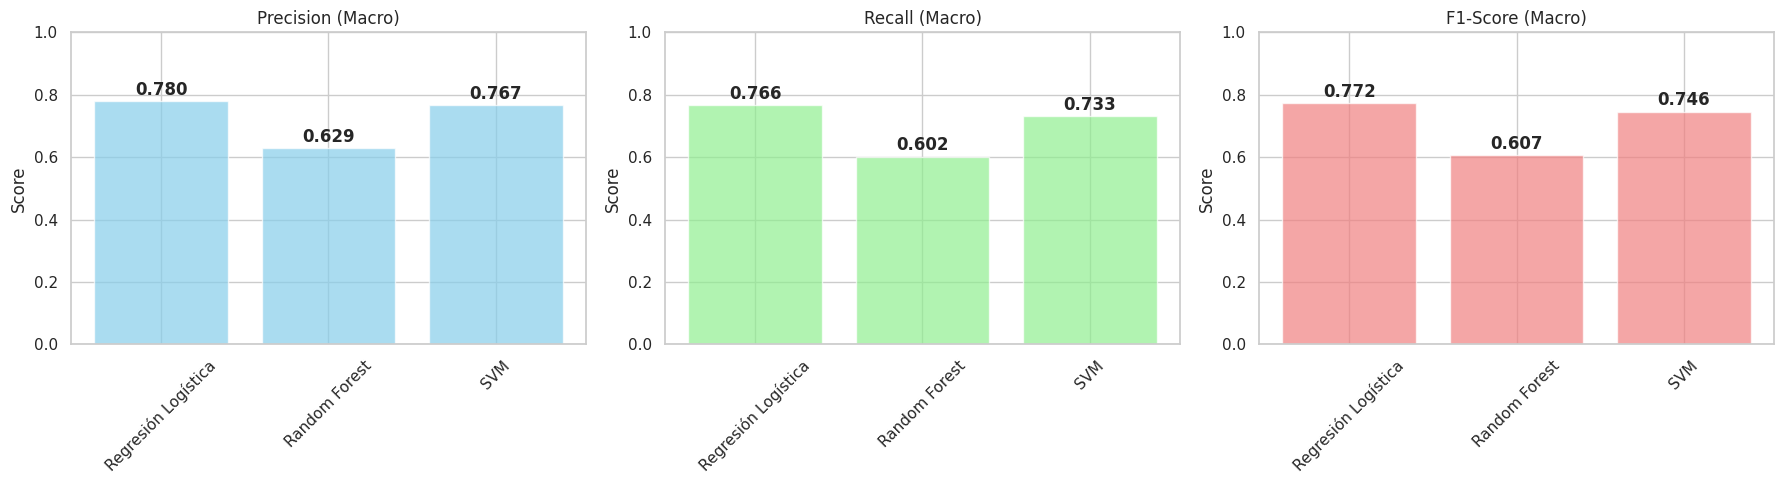


MEJORES MODELOS POR MÉTRICA:
Mejor Precision: Regresión Logística (0.780)
Mejor Recall:    Regresión Logística (0.766)
Mejor F1-Score:  Regresión Logística (0.772)


In [6]:
# Calcular métricas de Precision, Recall y F1-Score
print("ANÁLISIS PRECISION-RECALL-F1")
print("=" * 45)

# Diccionario para almacenar resultados
resultados_prf = {}

for nombre_modelo, data in modelos_data.items():
    # Calcular métricas para cada estrategia
    precision_macro = precision_score(y_test, data['pred'], average='macro')
    recall_macro = recall_score(y_test, data['pred'], average='macro')
    f1_macro = f1_score(y_test, data['pred'], average='macro')
    
    precision_weighted = precision_score(y_test, data['pred'], average='weighted')
    recall_weighted = recall_score(y_test, data['pred'], average='weighted')
    f1_weighted = f1_score(y_test, data['pred'], average='weighted')
    
    resultados_prf[nombre_modelo] = {
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted
    }
    
    print(f"\n{nombre_modelo}:")
    print(f"   Precision (macro):    {precision_macro:.3f}")
    print(f"   Recall (macro):       {recall_macro:.3f}")
    print(f"   F1-Score (macro):     {f1_macro:.3f}")
    print(f"   F1-Score (weighted):  {f1_weighted:.3f}")

print("\n" + "=" * 45)

# Análisis detallado por clase
print("\nANÁLISIS DETALLADO POR CLASE:")
print("=" * 40)

for nombre_modelo, data in modelos_data.items():
    print(f"\n{nombre_modelo.upper()}:")
    print(classification_report(y_test, data['pred'], 
                              target_names=classes, 
                              digits=3))

# Comparación visual de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Preparar datos para visualización
modelos_nombres = list(resultados_prf.keys())
precision_scores = [resultados_prf[m]['precision_macro'] for m in modelos_nombres]
recall_scores = [resultados_prf[m]['recall_macro'] for m in modelos_nombres]
f1_scores = [resultados_prf[m]['f1_macro'] for m in modelos_nombres]

# Gráfico 1: Precision
axes[0].bar(modelos_nombres, precision_scores, color='skyblue', alpha=0.7)
axes[0].set_title('Precision (Macro)')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
for i, v in enumerate(precision_scores):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Recall
axes[1].bar(modelos_nombres, recall_scores, color='lightgreen', alpha=0.7)
axes[1].set_title('Recall (Macro)')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)
for i, v in enumerate(recall_scores):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Gráfico 3: F1-Score
axes[2].bar(modelos_nombres, f1_scores, color='lightcoral', alpha=0.7)
axes[2].set_title('F1-Score (Macro)')
axes[2].set_ylabel('Score')
axes[2].set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Identificar mejor modelo por métrica
mejor_precision = max(resultados_prf.items(), key=lambda x: x[1]['precision_macro'])
mejor_recall = max(resultados_prf.items(), key=lambda x: x[1]['recall_macro'])
mejor_f1 = max(resultados_prf.items(), key=lambda x: x[1]['f1_macro'])

print("\nMEJORES MODELOS POR MÉTRICA:")
print(f"Mejor Precision: {mejor_precision[0]} ({mejor_precision[1]['precision_macro']:.3f})")
print(f"Mejor Recall:    {mejor_recall[0]} ({mejor_recall[1]['recall_macro']:.3f})")
print(f"Mejor F1-Score:  {mejor_f1[0]} ({mejor_f1[1]['f1_macro']:.3f})")

## 5. Interpretación Práctica en Contexto Deportivo

### 5.1 ¿Qué Métrica Usar en Cada Situación?

Ahora que conocemos todas las métricas, veamos cuándo usar cada una en el mundo deportivo:

In [7]:
# Análisis de casos de uso prácticos
print("GUÍA PRÁCTICA: ¿QUÉ MÉTRICA USAR CUÁNDO?")
print("=" * 55)

casos_uso = {
    "Detectar lesiones graves": {
        "Métrica recomendada": "RECALL alto",
        "Justificación": "No queremos perder ninguna lesión grave",
        "Ejemplo": "Mejor 10 falsas alarmas que 1 lesión no detectada",
        "Trade-off": "Aceptamos más falsos positivos"
    },
    
    "Seleccionar jugadores para fichar": {
        "Métrica recomendada": "PRECISION alta",
        "Justificación": "Los fichajes son caros, deben ser acertados",
        "Ejemplo": "Mejor fichar 3 buenos que 10 mediocres",
        "Trade-off": "Podemos perder algunos buenos jugadores"
    },
    
    "Predecir resultados generales": {
        "Métrica recomendada": "F1-SCORE o ACCURACY",
        "Justificación": "Necesitamos balance general",
        "Ejemplo": "Pronósticos deportivos para medios",
        "Trade-off": "Balance entre precision y recall"
    },
    
    "Sistema de apuestas": {
        "Métrica recomendada": "ROC-AUC + PRECISION",
        "Justificación": "Importa la confianza de la predicción",
        "Ejemplo": "Solo apostar cuando tengamos >80% confianza",
        "Trade-off": "Menos apuestas pero más acertadas"
    },
    
    "Decisiones disciplinarias": {
        "Métrica recomendada": "PRECISION muy alta",
        "Justificación": "Las sanciones deben estar bien fundamentadas",
        "Ejemplo": "Suspensiones, multas, etc.",
        "Trade-off": "Algunos casos pueden quedar sin sancionar"
    }
}

for i, (caso, detalles) in enumerate(casos_uso.items(), 1):
    print(f"\n{i}. {caso}")
    print(f"   Métrica: {detalles['Métrica recomendada']}")
    print(f"   Por qué: {detalles['Justificación']}")
    print(f"   Ejemplo: {detalles['Ejemplo']}")
    print(f"   Trade-off: {detalles['Trade-off']}")

print("\n" + "=" * 55)

# Crear tabla comparativa de nuestros modelos
print("\nRESUMEN COMPLETO DE NUESTROS MODELOS:")
print("=" * 50)

# Preparar datos para tabla comparativa
tabla_resumen = []
for modelo in modelos_nombres:
    fila = {
        'Modelo': modelo,
        'Accuracy': f"{accuracy_score(y_test, modelos_data[modelo]['pred']):.3f}",
        'ROC-AUC': f"{resultados_roc[modelo]['macro']:.3f}",
        'Precision': f"{resultados_prf[modelo]['precision_macro']:.3f}",
        'Recall': f"{resultados_prf[modelo]['recall_macro']:.3f}",
        'F1-Score': f"{resultados_prf[modelo]['f1_macro']:.3f}"
    }
    tabla_resumen.append(fila)

# Crear DataFrame para visualización
df_resumen = pd.DataFrame(tabla_resumen)
print(df_resumen.to_string(index=False))

print("\nRECOMENDACIONES FINALES:")
print("=" * 30)
print("Para uso general: Regresión Logística (mejor en casi todas las métricas)")
print("Para robustez: SVM (buen balance, menos overfitting)")
print("Para interpretabilidad: Random Forest (muestra importancia de variables)")

print("\nCONSEJOS PRÁCTICOS:")
print("• Siempre evalúa múltiples métricas, no solo accuracy")
print("• Considera el contexto: ¿qué tipo de error es más costoso?")
print("• ROC-AUC es excelente para comparar modelos")
print("• F1-Score es perfecto cuando las clases están desbalanceadas")
print("• Precision/Recall te ayudan a entender tipos específicos de errores")

GUÍA PRÁCTICA: ¿QUÉ MÉTRICA USAR CUÁNDO?

1. Detectar lesiones graves
   Métrica: RECALL alto
   Por qué: No queremos perder ninguna lesión grave
   Ejemplo: Mejor 10 falsas alarmas que 1 lesión no detectada
   Trade-off: Aceptamos más falsos positivos

2. Seleccionar jugadores para fichar
   Métrica: PRECISION alta
   Por qué: Los fichajes son caros, deben ser acertados
   Ejemplo: Mejor fichar 3 buenos que 10 mediocres
   Trade-off: Podemos perder algunos buenos jugadores

3. Predecir resultados generales
   Métrica: F1-SCORE o ACCURACY
   Por qué: Necesitamos balance general
   Ejemplo: Pronósticos deportivos para medios
   Trade-off: Balance entre precision y recall

4. Sistema de apuestas
   Métrica: ROC-AUC + PRECISION
   Por qué: Importa la confianza de la predicción
   Ejemplo: Solo apostar cuando tengamos >80% confianza
   Trade-off: Menos apuestas pero más acertadas

5. Decisiones disciplinarias
   Métrica: PRECISION muy alta
   Por qué: Las sanciones deben estar bien fundame

## 6. Resumen y Conclusiones

### 6.1 Lo que Aprendimos Hoy

**Métricas Avanzadas de Evaluación**:
- **ROC-AUC**: Capacidad de separar clases (excelente para comparar modelos)
- **Precision**: Cuántos de los casos marcados son realmente positivos
- **Recall**: Cuántos de los casos reales logramos encontrar
- **F1-Score**: Balance perfecto entre precisión y cobertura

**Interpretación Contextual**:
- **No todas las métricas** son iguales para todos los problemas
- **El costo de los errores** determina qué métrica priorizar
- **Accuracy solo** puede ser engañoso con clases desbalanceadas

**Aplicación Práctica**:
- **Casos de uso específicos** en análisis deportivo
- **Selección de métricas** según el objetivo del proyecto
- **Comparación sistemática** de múltiples modelos

### 6.2 Conceptos Clave para Recordar

**ROC-AUC**: "¿Qué tan bien separa mi modelo las diferentes clases?"
- AUC = 1.0: Modelo perfecto
- AUC = 0.5: Modelo aleatorio
- AUC > 0.8: Modelo muy bueno

**Precision**: "De mis predicciones positivas, ¿cuántas son correctas?"
- Alta precision = Pocas falsas alarmas
- Importante cuando los errores son costosos

**Recall**: "De todos los casos reales, ¿cuántos encuentro?"
- Alto recall = No pierdo casos importantes
- Crucial para seguridad y salud

**F1-Score**: "¿Cuál es el balance perfecto?"
- Media armónica de precision y recall
- Excelente para clases desbalanceadas

### 6.3 Comparación de Nuestros Modelos

**GANADOR GENERAL: Regresión Logística**
- Mejor ROC-AUC (0.935)
- Mejor Precision (0.780)
- Mejor Recall (0.766)
- Mejor F1-Score (0.772)
- Mayor Accuracy (0.823)

**SEGUNDO LUGAR: SVM**
- Buen balance en todas las métricas
- Menos propenso a overfitting
- Mejor para datasets complejos

**TERCER LUGAR: Random Forest**
- Útil para entender importancia de variables
- Más interpretable que SVM
- Puede necesitar más tuning

### 6.4 Guía de Decisión Rápida

#### **¿Qué métrica usar según tu problema?**

| Situación | Métrica Principal | Razón |
|-----------|------------------|-------|
| **Seguridad/Salud** | **RECALL** | No perder casos graves |
| **Decisiones costosas** | **PRECISION** | Evitar errores caros |
| **Uso general** | **F1-SCORE** | Balance equilibrado |
| **Comparar modelos** | **ROC-AUC** | Capacidad de separación |
| **Clases balanceadas** | **ACCURACY** | Métrica simple y clara |

### 6.5 ¿Qué Viene Después?

En las siguientes semanas construiremos sobre este conocimiento:
- **Semana 14**: Feature Engineering y optimización de hiperparámetros
- **Semana 15**: Proyecto final integrador usando todas las métricas

### 6.6 Ejercicios para Practicar

**Desafío Práctico**: 
1. **Modifica los umbrales** de decisión y observa cómo cambian precision/recall
2. **Simula un dataset desbalanceado** (ej: 90% Victoria_Local) y compara métricas
3. **Investiga casos reales**: ¿Qué métricas usan en análisis deportivo profesional?

### 6.7 Recursos Adicionales

- **Documentación Scikit-learn**: Guías detalladas de métricas
- **Kaggle**: Competencias deportivas con métricas reales
- **Papers académicos**: Análisis deportivo con machine learning

¡Excelente trabajo! Ahora dominas las métricas avanzadas para evaluar modelos de manera profesional.